In [1]:
import pystan
import numpy as np
from matplotlib import pyplot as plt

In [2]:
drdt = np.loadtxt("drdt.csv", delimiter=",", skiprows=1)

In [3]:
drdt

array([5.67623421e-04, 1.29366473e-03, 2.22112660e-03, 3.40392639e-03,
       4.90919812e-03, 6.81979242e-03, 9.23680032e-03, 1.22817906e-02,
       1.60982696e-02, 2.08516626e-02, 2.67269288e-02, 3.39228416e-02,
       4.26421402e-02, 5.30773152e-02, 6.53928019e-02, 7.97056643e-02,
       9.60680504e-02, 1.14455173e-01, 1.34761857e-01, 1.56808832e-01,
       1.80357541e-01, 2.05130335e-01, 2.30832089e-01, 2.57169768e-01,
       2.83867707e-01, 3.10677807e-01, 3.37384936e-01, 3.63808503e-01,
       3.89801327e-01, 4.15246845e-01, 4.40055505e-01, 4.64160900e-01,
       4.87516038e-01, 5.10089920e-01, 5.31864537e-01, 5.52832301e-01,
       5.72993888e-01, 5.92356443e-01, 6.10932121e-01, 6.28736891e-01,
       6.45789571e-01, 6.62111054e-01, 6.77723686e-01, 6.92650767e-01,
       7.06916162e-01, 7.20543985e-01, 7.33558353e-01, 7.45983199e-01,
       7.57842116e-01, 7.69158249e-01, 7.79954205e-01, 7.90251992e-01,
       8.00072972e-01, 8.09437831e-01, 8.18366558e-01, 8.26878438e-01,
      

In [4]:
y = drdt.cumsum()[1:]

In [5]:
stan_code = """ 
functions {
  real[] dr_dt(real t,
               real[] r,
               real[] theta,
               real[] x_r,
               int[] x_i) {    
    real beta = theta[1];
    real gamma = theta[2];
    real s0 = theta[3];
    real R0 = beta/gamma;
    real deriv [2];
    deriv[1] = gamma*(1-r[1]-s0*exp(-R0*r[1]));
    deriv[2] = 1;
    return deriv;
  }
}
data {
  int<lower = 0> n_obs; // Number of days sampled
  real ts[n_obs]; // Time points that were sampled
  real y_init; // initial measured population
  real y[n_obs]; // measured population at measurement times
}
transformed data{
  real xr[2] =  rep_array(0.0, 2);
  int xi[2] = rep_array(0, 2);
}
parameters {
  real<lower=0, upper=1> r_init[2]; // initial population
  real<lower=0> beta;
  real<lower=0> gamma;
  real<lower=0, upper=1> s0;
  real<lower=0> sigma;   // error scale
}
transformed parameters {
    real theta[3];   // theta = { beta, gamma, s0 }
    real  r[n_obs, 2];
    theta[1] = beta;
    theta[2] = gamma;
    theta[3] = s0;
    r = integrate_ode_rk45(dr_dt, r_init, 0, ts, theta,
                                         xr, xi,
                                         1e-6, 1e-5, 1e3);
}
model {
  beta ~ gamma(1, 1);
  gamma ~ gamma(1, 1);
  s0 ~ beta(5, 2);
  sigma ~ normal(0, 1);
  r_init ~ beta(2, 5);
  y_init ~ lognormal(log(r_init[1]), sigma);
  y ~ lognormal(log(r[, 1]), sigma);
}
generated quantities{
  real<lower=0> R0 = beta/gamma;
  real<lower=0> y_rep [n_obs];
  for (i in 1:n_obs) y_rep[i] = lognormal_rng(log(r[i, 1]), sigma);
}

"""
# make Stan model 
sm = pystan.StanModel(model_code=stan_code)
# fit = pystan.stan(model_code=stan_code, data=model_data, iter=5000, chains=3, verbose=True, n_jobs=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6bc0dbd4d6e5b5614012e39a2e73d5de NOW.


In [6]:
model_data = {'n_obs': y.size,
               'ts': np.arange(y.size) + 0.001,
               'y_init': 0.01,
               'y': y  
              }

In [7]:
fit = sm.sampling(data=model_data, iter=5000, chains=1, verbose=True, n_jobs=2)

In [8]:
print(fit)

Inference for Stan model: anon_model_6bc0dbd4d6e5b5614012e39a2e73d5de.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r_init[1]    0.1  1.9e-3    0.1 7.5e-3   0.04   0.07   0.14   0.36   2419    1.0
r_init[2]   0.29  3.1e-3   0.16   0.05   0.16   0.27    0.4   0.65   2870    1.0
beta        1.26    0.02   0.99   0.28   0.58   0.93   1.62   3.92   1791    1.0
gamma       0.14  3.5e-3   0.13   0.04   0.08   0.11   0.16   0.46   1314    1.0
s0          0.73  2.8e-3   0.16   0.37   0.64   0.76   0.86   0.96   3115    1.0
sigma       2.85  3.7e-3    0.2   2.49   2.71   2.84   2.98   3.25   2773    1.0
theta[1]    1.26    0.02   0.99   0.28   0.58   0.93   1.62   3.92   1791    1.0
theta[2]    0.14  3.5e-3   0.13   0.04   0.08   0.11   0.16   0.46   1314    1.0
theta[3]    0.73  2.8e-3   0.16   0.37   0.64   0.76   0.86   0.96   3115    1.0
r

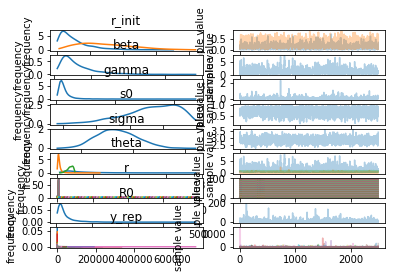

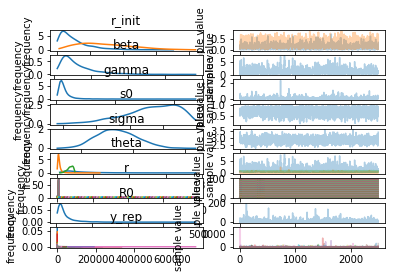

In [9]:
fit.plot() ## figure out a better plot